In [1]:
import json
import math
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

In [2]:
# Configurações do Pandas para melhor visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

# Configurações do Plotly
pio.templates.default = "plotly_white"

# Cria diretório para salvar imagens se não existir
OUTPUT_IMG_DIR = "imagens/"
if not os.path.exists(OUTPUT_IMG_DIR):
    os.makedirs(OUTPUT_IMG_DIR)

# --- PARÂMETROS DE CONFIGURAÇÃO DO PROJETO ---
CONFIG = {
    "FILES": {
        "GATEWAYS": 'lorawan_antwerp_gateway_locations.json',
        "DATASET": 'lorawan_antwerp_2019_dataset.json',
        "OUTPUT_JSON": 'gateway_calibration_results.json'
    },
    "FILTERS": {
        "HDOP_MAX": 5.0,
        "MIN_DISTANCE": 1.0, # Metros
        "BIN_SIZE": 10       # Metros (para suavização)
    },
    "CALIBRATION": {
        "USE_FIXED_N": False, # <--- DEFINE SE USA N FIXO OU CALCULADO
        "FIXED_N_VALUE": 2.7  # Usado apenas se USE_FIXED_N = True
    }
}

print("Configurações carregadas e diretórios verificados.")

Configurações carregadas e diretórios verificados.


In [3]:
def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calcula a distância em metros entre duas coordenadas geográficas (fórmula de Haversine).
    """
    R = 6371000  # Raio da Terra em metros
    
    if any(v is None for v in [lat1, lon1, lat2, lon2]):
        return float('inf')

    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

def log_path_loss_model(distance, A, n):
    """
    Retorna o RSSI esperado. 
    Vetorizado: Aceita float escalar ou Pandas Series/Numpy Array.
    """
    return A - (10 * n * np.log10(distance))

In [4]:
# Carregar Gateways
try:
    with open(CONFIG["FILES"]["GATEWAYS"], 'r') as f:
        gateway_locations = json.load(f)
    print(f"Localizações carregadas: {len(gateway_locations)} gateways.")
except FileNotFoundError:
    print(f"ERRO: Arquivo {CONFIG['FILES']['GATEWAYS']} não encontrado.")
    gateway_locations = {}

# Carregar Dataset e Criar DataFrame de Calibração
calibration_data = []

try:
    df_raw = pd.read_json(CONFIG["FILES"]["DATASET"])
    
    # Filtragem inicial por qualidade do GPS
    df_filtered = df_raw[df_raw['hdop'] <= CONFIG["FILTERS"]["HDOP_MAX"]].copy()
    print(f"Registros válidos para processamento: {len(df_filtered)}")

    # Loop de extração
    for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="Processando Distâncias"):
        gt_lat, gt_lon = row['latitude'], row['longitude']

        if not isinstance(row['gateways'], list):
            continue

        for gw in row['gateways']:
            gw_id = gw.get('id')
            rssi = gw.get('rssi')

            if gw_id not in gateway_locations or rssi is None:
                continue

            gw_loc = gateway_locations[gw_id]
            dist = haversine(gt_lat, gt_lon, gw_loc.get('latitude'), gw_loc.get('longitude'))

            if dist >= CONFIG["FILTERS"]["MIN_DISTANCE"]:
                calibration_data.append({
                    'AnchorID': gw_id,
                    'RSSI': rssi,
                    'Distance': dist
                })
    
    df_cal = pd.DataFrame(calibration_data)
    print(f"DataFrame de calibração criado: {len(df_cal)} registros.")

except FileNotFoundError:
    print("ERRO: Dataset principal não encontrado.")
    df_cal = pd.DataFrame()

Localizações carregadas: 249 gateways.
Registros válidos para processamento: 129830


Processando Distâncias:   0%|          | 0/129830 [00:00<?, ?it/s]

DataFrame de calibração criado: 357837 registros.


In [5]:
def perform_calibration(df_data: pd.DataFrame, use_fixed_n: bool, fixed_n: float = 2.0):
    """
    Executa a calibração para encontrar A (RSSI ref) e n (path loss exponent).
    Retorna um dicionário de resultados e o DataFrame com médias agrupadas.
    """
    
    # 1. Agrupamento espacial (Binning) para reduzir ruído
    bin_size = CONFIG["FILTERS"]["BIN_SIZE"]
    df_data['Distance_Bin'] = (df_data['Distance'] / bin_size).round() * bin_size
    
    # Remove bins 0 ou muito pequenos para evitar log(0) ou log(negativo)
    df_data = df_data[df_data['Distance_Bin'] >= 1].copy() 
    
    df_mean = df_data.groupby(['AnchorID', 'Distance_Bin'])['RSSI'].mean().reset_index()
    
    results = {}
    anchor_ids = df_mean['AnchorID'].unique()
    
    print(f"Iniciando calibração (Modo: {'N FIXO' if use_fixed_n else 'REGRESSÃO LINEAR'})...")

    for anchor in anchor_ids:
        df_anchor = df_mean[df_mean['AnchorID'] == anchor].copy()
        
        # Requer mínimo de pontos para estatística
        if len(df_anchor) < 5: 
            continue

        X_log = np.log10(df_anchor['Distance_Bin'].values) # Log da distância
        y_rssi = df_anchor['RSSI'].values

        if use_fixed_n:
            # Se n é fixo, isolamos A: A = RSSI + 10 * n * log10(d)
            path_loss_factor = 10 * fixed_n
            A_estimates = y_rssi + (path_loss_factor * X_log)
            
            final_A = np.mean(A_estimates)
            final_n = fixed_n
            
        else:
            # Regressão Linear: y = mx + b
            model = LinearRegression()
            model.fit(X_log.reshape(-1, 1), y_rssi)
            
            final_A = model.intercept_
            m = model.coef_[0]
            final_n = m / -10.0

        results[anchor] = {
            'A': final_A,
            'n': final_n,
            'count': len(df_anchor)
        }
        
        # Adiciona coluna de RSSI estimado pelo modelo para plotagem futura
        # Agora funciona pois log_path_loss_model aceita a Series inteira
        mask = (df_mean['AnchorID'] == anchor)
        df_mean.loc[mask, 'RSSImodel'] = log_path_loss_model(
            df_mean.loc[mask, 'Distance_Bin'], final_A, final_n
        )

    return results, df_mean

# Executa a função
calib_results, df_mean_calibrated = perform_calibration(
    df_cal, 
    use_fixed_n=CONFIG["CALIBRATION"]["USE_FIXED_N"],
    fixed_n=CONFIG["CALIBRATION"]["FIXED_N_VALUE"]
)

# Exibe resumo global
if calib_results:
    avg_A = np.mean([r['A'] for r in calib_results.values()])
    avg_n = np.mean([r['n'] for r in calib_results.values()])
    print("-" * 40)
    print(f"Calibração Concluída para {len(calib_results)} âncoras.")
    print(f"Média Global -> A: {avg_A:.2f} dBm | n: {avg_n:.3f}")
    print("-" * 40)
else:
    print("Não foi possível calibrar nenhuma âncora (dados insuficientes).")

Iniciando calibração (Modo: REGRESSÃO LINEAR)...
----------------------------------------
Calibração Concluída para 36 âncoras.
Média Global -> A: -45.83 dBm | n: 1.677
----------------------------------------


In [6]:
output_payload = {
    "config_used": CONFIG["CALIBRATION"],
    "global_metrics": {
        "A_avg": np.mean([r['A'] for r in calib_results.values()]) if calib_results else 0,
        "n_avg": np.mean([r['n'] for r in calib_results.values()]) if calib_results else 0
    },
    "gateways": calib_results
}

with open(CONFIG["FILES"]["OUTPUT_JSON"], 'w') as f:
    json.dump(output_payload, f, indent=4)

print(f"Arquivo de parâmetros salvo em: {CONFIG['FILES']['OUTPUT_JSON']}")

Arquivo de parâmetros salvo em: gateway_calibration_results.json


Imagem salva em: imagens/calibration_plot_variable_n.png (Visualização abaixo inclui título para contexto)


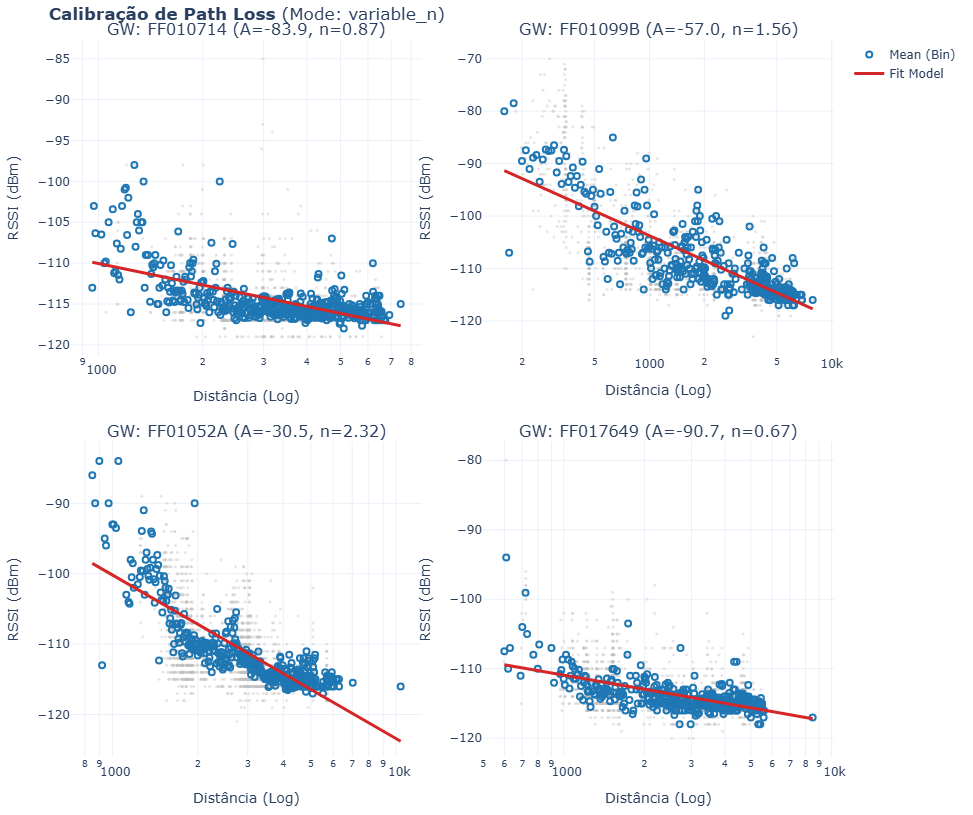

In [7]:
# Seleciona 4 âncoras para plotar
if calib_results:
    top_anchors = sorted(calib_results, key=lambda k: calib_results[k]['count'], reverse=True)[:4]

    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[f"GW: {aid} (A={calib_results[aid]['A']:.1f}, n={calib_results[aid]['n']:.2f})" for aid in top_anchors],
        vertical_spacing=0.12,
        horizontal_spacing=0.08
    )

    row, col = 1, 1
    for anchor_id in top_anchors:
        
        # Dados de modelo (Médias Agrupadas)
        df_model = df_mean_calibrated[df_mean_calibrated['AnchorID'] == anchor_id].sort_values('Distance_Bin')
        
        # Dados Brutos (Amostra para performance)
        df_raw_points = df_cal[df_cal['AnchorID'] == anchor_id]
        if len(df_raw_points) > 2000:
            df_raw_points = df_raw_points.sample(2000)

        # 1. Scatter Dados Brutos (Fundo)
        fig.add_trace(
            go.Scatter(
                x=df_raw_points['Distance'], y=df_raw_points['RSSI'],
                mode='markers', name='Raw Data',
                marker=dict(color='silver', opacity=0.4, size=3),
                showlegend=False
            ), row=row, col=col
        )

        # 2. Scatter Médias (Bins)
        fig.add_trace(
            go.Scatter(
                x=df_model['Distance_Bin'], y=df_model['RSSI'],
                mode='markers', name='Mean (Bin)',
                marker=dict(color='#1f77b4', size=6, symbol='circle-open', line=dict(width=2)),
                showlegend=(row==1 and col==1)
            ), row=row, col=col
        )

        # 3. Linha do Modelo Ajustado
        fig.add_trace(
            go.Scatter(
                x=df_model['Distance_Bin'], y=df_model['RSSImodel'],
                mode='lines', name='Fit Model',
                line=dict(color='#d62728', width=3),
                showlegend=(row==1 and col==1)
            ), row=row, col=col
        )

        # Configuração dos eixos
        fig.update_xaxes(title_text="Distância (Log)", type="log", row=row, col=col)
        fig.update_yaxes(title_text="RSSI (dBm)", row=row, col=col)

        col += 1
        if col > 2:
            col = 1
            row += 1

    # --- SALVAR IMAGEM LIMPA (SEM TÍTULO) ---
    fig.update_layout(
        height=800, width=1000,
        margin=dict(l=20, r=20, t=40, b=20),
        template="plotly_white"
    )
    
    # Define nome do arquivo baseado no modo
    mode_str = "fixed_n" if CONFIG["CALIBRATION"]["USE_FIXED_N"] else "variable_n"
    filename = f"{OUTPUT_IMG_DIR}calibration_plot_{mode_str}.png"
    
    # Salva imagem estática de alta qualidade
    fig.write_image(filename, scale=2) 
    print(f"Imagem salva em: {filename} (Visualização abaixo inclui título para contexto)")

    # --- EXIBIR COM TÍTULO ---
    fig.update_layout(title_text=f"<b>Calibração de Path Loss</b> (Mode: {mode_str})")
    fig.show()
else:
    print("Sem dados suficientes para plotagem.")